# StackOverflow Analysis

Popular question and answer (qna) site - stackoverflow (& their sister sites - http://stackexchange.com/sites) witnesses tremendous activity daily where netizens post questions, recieve answers, comments and engage in an active discussion. 

We want to analyze this data with the intention to identify __related__ questions. In general, the analysis presented in this notebook can be used in a variety of scenarios. Some illustrative examples include

* Power users use multiple browser tabs simultaneously. Using the techniques outlined below, we can identify and group similar tabs together. With the appropriate visual cues, similar tabs can be identified at a glance.

* Many products provide a twitter handle to offer support. User questions about the product or service related queries (all within the twitter 140 char limit) can be grouped based on similarity.

The Stack Exchange network uploads monthly dumps of their data which we have used for analysis.

> "The anonymized dump of all user-contributed content on the Stack Exchange network. Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

> All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump."

** From : https://archive.org/details/stackexchange **


## Schema & Data Munging

The schema for their data is located @ https://ia800500.us.archive.org/22/items/stackexchange/readme.txt.
    
However,

* All the data is dumped in XML format. So we need to write a converter to convert the XML data into a tabular format.
* Since the size of data is huge, we need to load data in a streaming fashion. 
* All the exchange sites share identical schema!


The first step is to then write a converter which does this. Our [Streaming XML2CSV Converter](convertso2csv.py) expects input data to be present at [input/english](input/english) for english.stackexchange.com, [input/aviation](input/aviation) for aviation.stackexchange.com etc. Similarly, the converted data is dumped at [output/english](output/english) and [output/aviation](output/aviation) respectively.

Also, note the converter outputs the csv file in a zipped format as pandas (the lib we use to read data) understands zip formats natively.

Please download the data from https://archive.org/download/stackexchange/english.stackexchange.com.7z and https://archive.org/download/stackexchange/aviation.stackexchange.com.7z into the input folders to run the dashboard. Alternatively, a sample run output has been stored in the respective output folders.


In [143]:
#imports
import warnings
warnings.filterwarnings('ignore')

import os
import os.path

import pandas as pd
import numpy as np
import math
import re

import gensim
from gensim import corpora, models,similarities
from gensim.models import Doc2Vec, TfidfModel

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from pprint import pprint                        # pretty-printer

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from wordcloud import WordCloud

SAMPLE_SIZE = 20000
RECOMPUTE_MODEL = True

SITE1 = 'biology' #.stackexchange.com
SITE2 = 'bicycles' #.stackexchange.com
SITES = [SITE1, SITE2]

samples = {}
samples[SITE1] = [
    'Why are the human knees and elbows bent in an opposite direction',
    'How would one determine whether a chemical will upregulate a certain class of proteins?'
]
samples[SITE2] = [
    'Picking a bike for a cyclist new to riding on the road?',
    'max weight that the shimano Rs400 can carry ?'
]


stopw = {}
stopw[SITE1] = ['biology', 'human', 'cell', 'dna', 'protein','doe']
stopw[SITE2] = ['bike','bicycle','bikes','bicycles']

In [144]:
# Global variables
Posts = {}
Dictionaries = {}
Corpora = {}
TFIDF = {}
NUM_TOPICS = {}
STOPW = {}

## 0. Convert Data from XML to CSV

In [145]:
#%%bash
#set XXX = 'chemistry'
#curl https://archive.org/download/stackexchange/$XXX.stackexchange.com.7z

In [146]:
from convertso2csv import process

# To get a new network, do the following
# wget https://archive.org/download/stackexchange/XXX.stackexchange.com.7z  [XXX=chemistry, physics etc]
# Extract the zip into input/XXX folder and then run this cell.
process(os.getcwd() + '/input')

skipping aviation...
skipping english...
skipping astronomy...
skipping biology...
skipping chemistry...
skipping bicycles...


# Data loading

For the purposes of this analysis, we use only post title and body. However, we will show the other data also made available to us from stackexchange. This can be used to further enrich the analysis. But this is not done in the current notebook.

### Note :

The original data is large. So to play around with the data, we have provide some knobs to tune within the notebooks (versus putting them in the parser)

1. ** SAMPLE_SIZE **  (#default value as 20k records)
2. ** SITE1 ** (#default value is english)
3. ** SITE2 ** (#default value is aviation)

Feel free to change this value to experiment or get better results.

### 1. Load SITE1 stackexchange data.

In [147]:
path = 'output/'+SITE1+'/'+'posts.csv.gz'
Posts[SITE1] = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
Posts[SITE1]['Tags'] = Posts[SITE1]['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))
Posts[SITE1][['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,in prokaryotic translation how critical for e...,what is the criticality of the ribosome bindin...,ribosome binding-sites translation synthet...
1,does anyone have any suggestions to prevent rn...,how is rnase contamination in rna based experi...,rna biochemistry


### 2. Load the SITE2 stackexchange data.

In [148]:
path = 'output/'+SITE2+'/'+'posts.csv.gz'
Posts[SITE2] = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
Posts[SITE2]['Tags'] = Posts[SITE2]['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))
Posts[SITE2][['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,i keep losing pressure in my tires and among ...,can i use a presta tube in a schrader rim,mountain-bike innertube presta schrader
1,are there adjustments that can be made instead...,what is the easiest way to fix a loose chain,chain


Related data can also be loaded. However, for the purposes of this demonstration, we are not exploiting the data from the tables below.

In [149]:
path = 'output/'+SITE2+'/'+'comments.csv.gz'
comments = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna()
comments[['Score','Text']].head(5)

,Score,Text
0,0,do you mean measure a frame of unknown dimensi...
1,0,the specified height of a frame i already bou...
2,0,thanks i ll do that
3,2,be sure to bend and flex the casing of the tir...
4,0,what kind of valve i know only very very old...


In [150]:
path='output/'+SITE1+'/'+'posthistory.csv.gz'
posthistory = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Text'])
posthistory[['Text']].head(5)

,Text
0,i was wondering whether you know how critical ...
1,ribosome binding site
3,does anyone have any suggestions to prevent rn...
4,preventing rnase contamination in rna based ex...
6,tortora writes in principles of anatomy and p...


In [151]:
path='output/' + SITE1 + '/' + 'users.csv.gz'
users = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['AboutMe','Location'])
users[['Location','AboutMe']].head(5)

,Location,AboutMe
0,on the server farm,hi i m not really a person i m a background ...
1,,being an alice in the world of computing can ...
2,new york united states,i m a former stack exchange employee for all...
3,corvallis or,developer on the stack overflow team find me...
4,winston salem nc,stack overflow valued associate twitter nick...


### Note

The relationship between all these tables and the detailed meaning of all the attributes and values can be found @
https://ia800500.us.archive.org/22/items/stackexchange/readme.txt
    

## Data cleansing - Stop Words & Word Stems

Once the data is loaded, we want to remove all the stop words present in the raw data. The ** stop_words ** instance can be used for the remainder of the program to achieve this.

In [152]:
class StopWords():
    lemma = WordNetLemmatizer()
    #stemmer = SnowballStemmer("english")
    #stemmer = LancasterStemmer()
    
    def __init__(self,add=[]):
        self.stop_words = stopwords.words('english')
        self.stop_words.append('use')
        for word in add:
            self.stop_words.append(word)

    def remove(self, sentence):
        line = [StopWords.lemma.lemmatize(tok) for tok in sentence.split()]
        return [tok for tok in line if not tok in self.stop_words and len(tok) > 1]    

In [153]:
class SentenceTokens():
    def __init__(self,df,field,sw):
        self.field = field
        self.df = df
        self.sw = sw
    
    def __iter__(self):

        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]
            
            #SentenceTokens.stemmer.stem(tok)
            yield [tok for tok in self.sw.remove(raw_sentence)]

In [154]:
def get_dictionary(site, posts, force=False):
    dictFile = 'models/' + site + '_posts.dict'

    # Check if trained model file exists
    if ( os.path.isfile(dictFile) and not force):
        dictionary = corpora.Dictionary.load(dictFile)
    else:
        #How frequently each term occurs within each document? We construct a document-term matrix.
        dictionary = corpora.Dictionary(posts)
        dictionary.filter_extremes(no_below=5, no_above=10)
        # store the dictionary, for future reference
        dictionary.save(dictFile) 

    return dictionary

# Bag of words
# corpus is a list of vectors equal to the number of documents. 
# In each document vector is a series of tuples. 
def get_corpus(site, posts, force=False):
    corpusFile = 'models/' + site + '_posts.mm'
    
    # Check if corpus file is found
    if ( os.path.isfile(corpusFile) and not force ):
        corpus = corpora.MmCorpus(corpusFile)
    else:
        # Create corpus
        corpus = [Dictionaries[site].doc2bow(post) for post in posts]
        
        # Store corpus to file
        corpora.MmCorpus.serialize(corpusFile, corpus) #Save the bow corpus
        
    return corpus

In [155]:
for site in SITES:
    STOPW[site] = StopWords(stopw.get(site,[]))
    stokens = SentenceTokens(Posts[site],'Title',STOPW[site])
    Dictionaries[site] = get_dictionary(site, stokens, force=RECOMPUTE_MODEL)
    Corpora[site] = get_corpus(site, stokens, force=RECOMPUTE_MODEL)
    TFIDF[site] = TfidfModel(Corpora[site], normalize=RECOMPUTE_MODEL)

['biology', 'human', 'cell', 'dna', 'protein', 'doe']
['bike', 'bicycle', 'bikes', 'bicycles']


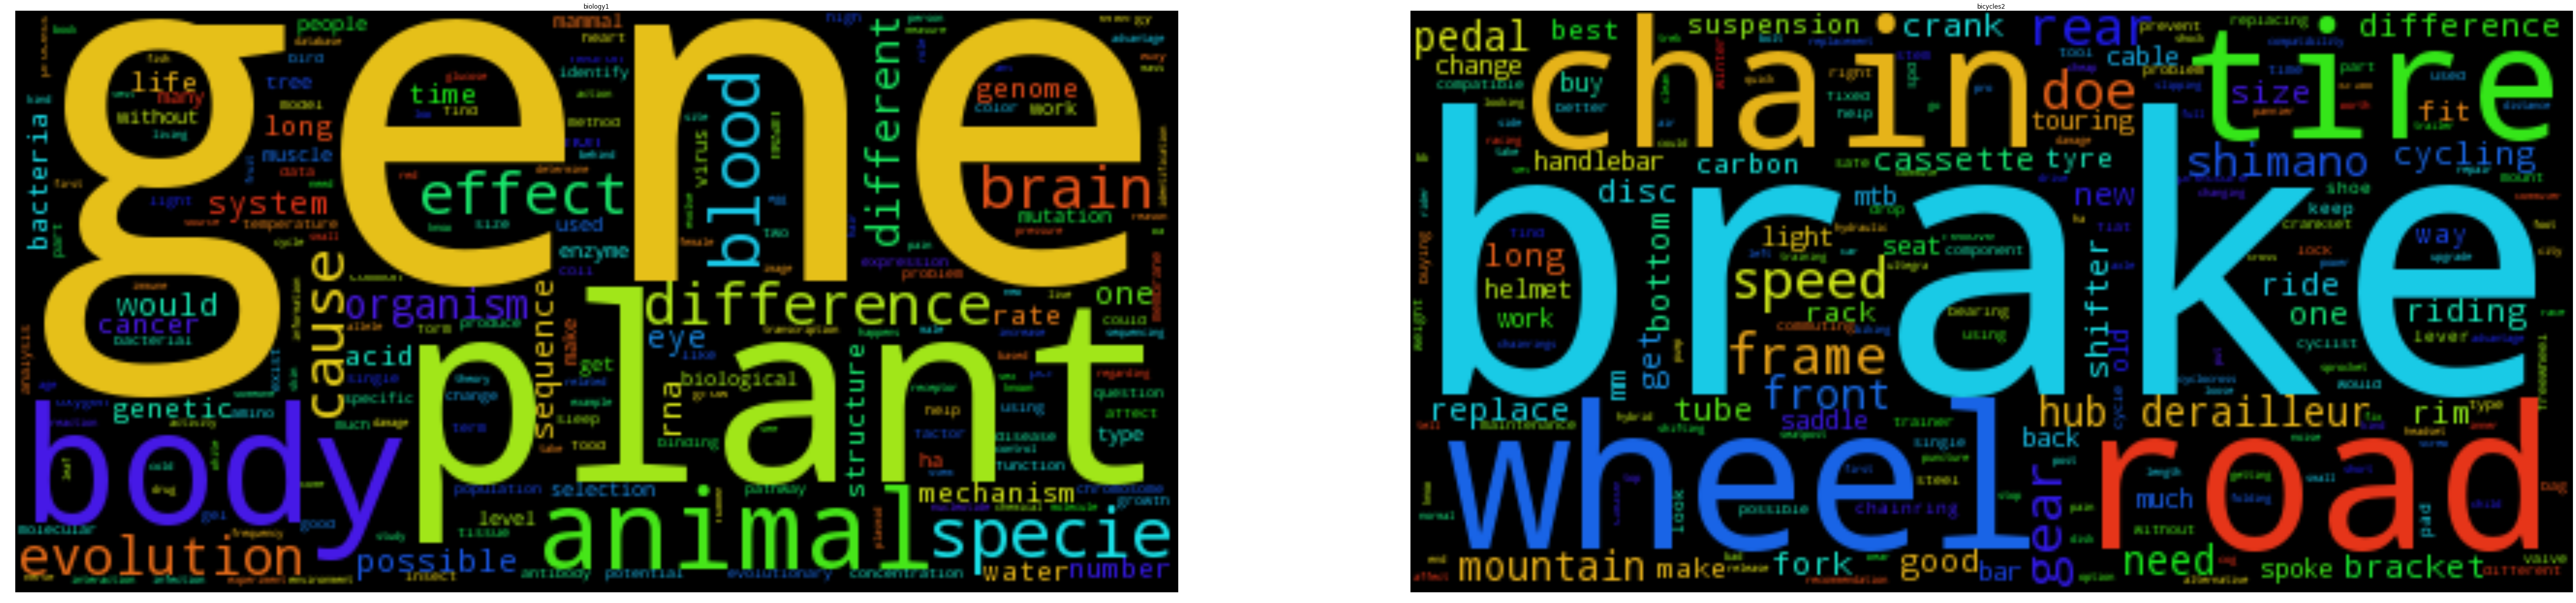

In [156]:
# Has to be better way to do this
def getWordOccurencesInCorpus(site):
    wordfreq = {}
    for row in Corpora[site]:
        for words in row:
            w = Dictionaries[site].get(words[0])
            if w in wordfreq:
                wordfreq[w] += words[1]
            else:
                wordfreq[w] = 1        
    freqs = []
    for k in wordfreq:
        freqs.append((k,(wordfreq[k])))
    return freqs

fig = plt.figure(figsize=(30*3, 30))
plotId=1
for site in SITES:
    wfreq = getWordOccurencesInCorpus(site)
    plt.subplot(120+plotId)
    plt.imshow(WordCloud().fit_words(wfreq))
    plt.axis("off")
    plt.title(site + `plotId`)
    plotId +=1
    
plt.show()

## 1. Find out the number of topics
===========================================

We were not aware of the number of topic, so we decided to reduce the number of features to two dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. 

One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 2D.

In [157]:
def get_lsi_model(site, dictionary, corpus, force = False):
    lsimodelFile = 'models/' + site + '_lsi.model'
    
    # Check if corpus file is found
    if ( os.path.isfile(lsimodelFile) and not force):
        lsimodel = models.LsiModel.load(lsimodelFile)
    else:
        lsimodel = models.LsiModel(TFIDF[site][Corpora[site]], id2word=dictionary, num_topics=NUM_TOPICS[site])
        lsimodel.save(lsimodelFile)

    return lsimodel   

In [158]:
# Get LSI Model
LsiModels = {}

for site in SITES:
    NUM_TOPICS[site] = 2
    LsiModels[site] = get_lsi_model(site, Dictionaries[site], Corpora[site], force=RECOMPUTE_MODEL)

In [159]:
def getWordCloud(line):
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        if word.startswith('"') and word.endswith('"'):
            word = word[1:-1]
        freqs.append((word, score))
    return WordCloud().fit_words(freqs)    

def plotWordCloud(site, model, num_topics = None, num_words=6):
    plotId = 1
    figureId = 1
    if num_topics is None:
        num_topics = NUM_TOPICS[site]

    for line in model.print_topics(num_topics,num_words):
            if plotId % 2 != 0:            
                plotId = 1
                plt.figure(figureId,figsize=(5*3, 5))

            plt.subplot(120+plotId)
            plt.imshow(getWordCloud(line[1]))
            plt.axis("off")
            plt.title(site + `figureId`)
            plotId += 1
            figureId +=1

    plt.show()

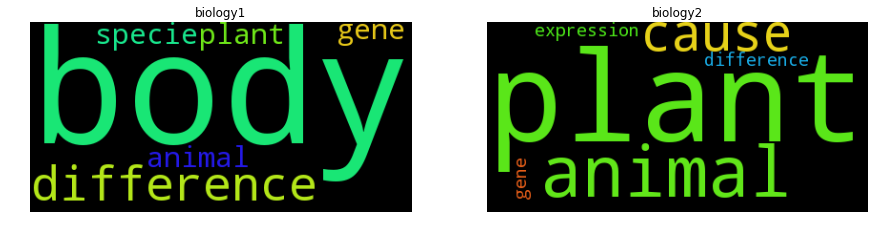

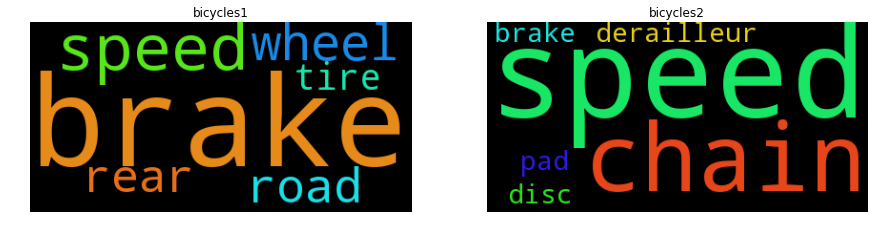

In [160]:
for site in SITES:
  plotWordCloud(site, LsiModels[site], 6)

We clustered the points in the this reduced space using KMeans, varying the number of clusters (K) from 1 to 10. 
We used the Inertia of the cluster provided by Scikit-Learn KMeans algorithm. 

** Ref ** : http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means


## From the above analysis, we will use number of clusters as 5

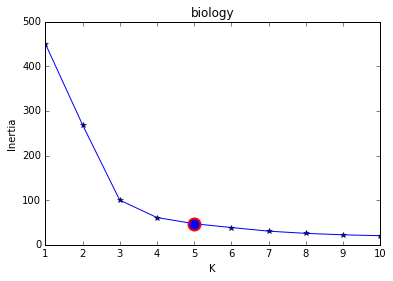

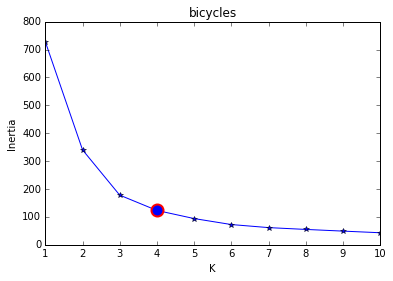

In [161]:
X = {}

for site in SITES:
    D = ''
    for vector in LsiModels[site][Corpora[site]]:
        if 2 == len(vector):
            #'1 2; 3 4' => 2 X 2
            D = D + `round(vector[0][1],4)` + ' ' + `round(vector[1][1],4)` + ';'

    X[site] = np.matrix(D[:-1])

    MAX_K = 10
    ks = range(1, MAX_K + 1)

    inertias = np.zeros(MAX_K)
    diff = np.zeros(MAX_K)
    diff2 = np.zeros(MAX_K)
    diff3 = np.zeros(MAX_K)
    for k in ks:
        kmeans = KMeans(k).fit(X[site])
        inertias[k - 1] = kmeans.inertia_
        # first difference    
        if k > 1:
            diff[k - 1] = inertias[k - 1] - inertias[k - 2]
        # second difference
        if k > 2:
            diff2[k - 1] = diff[k - 1] - diff[k - 2]
        # third difference
        if k > 3:
            diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

    elbow = np.argmin(diff3[3:]) + 3

    plt.plot(ks, inertias, "b*-")
    plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
             markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
    plt.ylabel("Inertia")
    plt.xlabel("K")
    plt.title(site)
    plt.show()

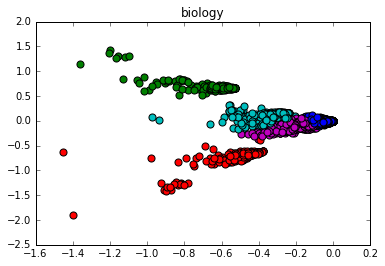

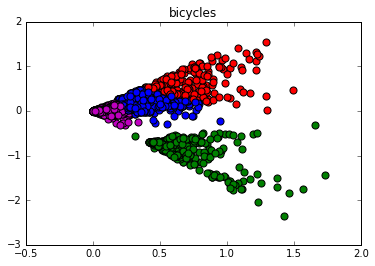

In [162]:
NUM_TOPICS = {}
NUM_TOPICS[SITE1] = 5
NUM_TOPICS[SITE2] = 4

#plotId = 1

for site in SITES:
    kmeans = KMeans(NUM_TOPICS[site]).fit(X[site])
    y = kmeans.labels_
    colors = ["b", "g", "r", "m", "c", "p", "y"] #Not expecting more than 5 for the data size
    #plt.subplot(120+plotId)
    for i in range(X[site].shape[0]):
        plt.scatter(X[site][i,0] ,X[site][i,1], c=colors[y[i]], s=50)    
    plt.title(site)
    plt.show()
    #plotId +=1

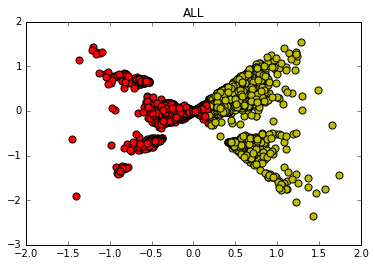

In [165]:
D = ''
for site in SITES:    
    for vector in LsiModels[site][Corpora[site]]:
        if 2 == len(vector):
            #'1 2; 3 4' => 2 X 2
            D = D + `round(vector[0][1],4)` + ' ' + `round(vector[1][1],4)` + ';'

X['ALL'] = np.matrix(D[:-1])
kmeans = KMeans(2).fit(X['ALL'])
y = kmeans.labels_
colors = ["r", "y",] 
#plt.subplot(120+plotId)
for i in range(X['ALL'].shape[0]):
    plt.scatter(X['ALL'][i,0] ,X['ALL'][i,1], c=colors[y[i]], s=50)    
plt.title('ALL')
plt.show()


## 2. Sample Search Demonstration
=============================================

In this section, we take a sample question, remove the stop words, and search using the LSI Model just created. We visually inspect the output for correctness.

In [ ]:
def QSim(site, document): # Query function for document
    # Apply stop words
    doc_processed = STOPW[site].remove(document)
    # create vector
    vec_bow = Dictionaries[site].doc2bow(doc_processed)
    # convert the query (sample vector) to LSI space
    vec_lsi = LsiModels[site][vec_bow]
    corpus = Corpora[site]
    # find indexes of similar sims
    index = similarities.MatrixSimilarity(LsiModels[site][corpus]) 
    # perform a similarity query against the corpus
    sims = index[vec_lsi]
    return sims

In [ ]:
site = SITE2
target = samples[site][1]
# Search for similar documents
sims = QSim(site,target)
# Sort in descending order - highest matching percentage on top
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims_list = list(enumerate(sorted_sims))

print("Search results for [{}]:".format(target))

# Show top 10 matches only
for i in range(0, 10):
    docid = sims_list[i][1][0]
    matchPercentage = sims_list[i][1][1]
    print("{:10.3f}% : {}".format(matchPercentage * 100, Posts[site].iloc[docid]['Title']))

## 3. Run the entire corpus against LDA to identify topics

The LDA algorithm is run with the number of topics set to the value found in the preceding steps.

In [ ]:
def get_lda_model(site, dictionary, corpus, force=False):
    modelFile = 'models/' + site + '_lda.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(modelFile) and not force):
        # load trained model from file
        ldamodel =  models.LdaModel.load(modelFile)
    else:
        # Create model
        
        #num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        #id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        #passes: optional. The number of laps the model will take through corpus.
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS[site], id2word = dictionary, passes=30)

        # save model to disk (no need to use pickle module)
        ldamodel.save(modelFile)

    return ldamodel

In [ ]:
# Get LDA Models
LdaModels = {}
for site in SITES:
    LdaModels[site] = get_lda_model(site, Dictionaries[site], Corpora[site], force=RECOMPUTE_MODEL)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [ ]:
@interact(num_topics=NUM_TOPICS[SITE1] + 5, num_words=3)
def understand(num_topics, num_words):   
   plotWordCloud(SITE1,LdaModels[SITE1],num_topics,num_words)
   return LdaModels[SITE1].print_topics(num_topics, num_words)

In [ ]:
@interact(num_topics=NUM_TOPICS[SITE2] + 5, num_words=3)
def understand(num_topics, num_words):
   plotWordCloud(SITE2,LdaModels[SITE2],num_topics,num_words)
   return LdaModels[SITE2].print_topics(num_topics, num_words)

## 4. Visualize the Model

LDAvis is a web-based interactive visualization of topics estimated using Latent Dirichlet Allocation. The visualization provides a global view of the topics (and how they differ from each other), while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic.

** Ref ** : 2014 ACL Workshop on Interactive Language Learning, Visualization, and Interfaces http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [ ]:
#for site in SITES:
site = SITE1
pyLDAvis.gensim.prepare(LdaModels[site],Corpora[site],Dictionaries[site])

<img src='images/ldaop.png'> <!-- Only shown as nb does not capture this output -->

# Approach 2 : Doc2Vec
===================================

In [ ]:
class LabeledLineSentence(object):
    def __init__(self,df,field,tag):
        self.df = df
        self.field = field
        self.tag = tag

    def __iter__(self):
        for index, row in self.df.iterrows():
            tokens = stop_words.remove(row[self.field])
            yield doc2vec.TaggedDocument(words=tokens,tags=[row[self.tag]])

In [ ]:
def get_doc2vec(force=False):
    doc2vecFile = 'doc2vec.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(doc2vecFile) and not force):
        # load trained model from file
        docmodel = Doc2Vec.load(doc2vecFile)
    else:
        lablines = LabeledLineSentence(posts,'Title','Id')
        
        # Create model
        docmodel = doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
        docmodel.build_vocab(lablines)

        for epoch in range(10):
            docmodel.train(lablines)
            docmodel.alpha -= 0.002  # decrease the learning rate
            docmodel.min_alpha = docmodel.alpha  # fix the learning rate, no decay

        # Save model
        docmodel.save(doc2vecFile)
        
    return docmodel

In [ ]:
docmodel = get_doc2vec()

In [ ]:
class MatchingPost(object):
    matchingPercentage = 0
    title = ""
    
    def __init__(self, matchingPercentage, title):
        self.matchingPercentage = matchingPercentage
        self.title = title        

## Doc2Vec: Sample Search

In [ ]:
def showsimilar(question):
    if (type(question) is not 'str'):
        question = str(question)
        
    norm_input = stop_words.remove(question) # question.split()
    q_vector = docmodel.infer_vector(norm_input)
    similar_vecs = docmodel.docvecs.most_similar(positive=[q_vector])
    similarTitles = []
    
    for vec in similar_vecs:
        post = posts[posts['Id']==vec[0]]
        if(len(post) == 0): continue
        title = posts[posts['Id']==vec[0]]['Title']
        similarPostInfo = MatchingPost(vec[1], title.iloc[0])
        similarTitles.append(similarPostInfo)
    
    print("Search results for [{}]:".format(question))
    
    # Show top 10 matches only
    for title in similarTitles:
        post = title.title
        matchPercentage = title.matchingPercentage
        print("{:10.2f}% : {}".format(matchPercentage * 100, post))

    return similarTitles

In [ ]:
# Find similar questions
similarTitles = showsimilar(samples[0])

In [ ]:
from IPython.display import display
from ipywidgets import widgets 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def handler(sender):
    showsimilar(text.value)
    
text = widgets.Text()    
display(text)    
text.on_submit(handler)


# Experimental : Try T-SNE 
=======================================

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
tfidf = {}
featurenames = {}
for site in SITES:
    tfidf[site] = tf.fit_transform([p['Title'] for i, p in Posts[site].iterrows()])
    featurenames[site] = tf.get_feature_names() 
#dense = tfidf_matrix.todense()
#len(feature_names)
#feature_names[50:70]

In [ ]:
tsne = {}
for site in SITES:
    X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf[site])
    tsne[site] = TSNE(learning_rate=10,n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

In [ ]:
'''
X_pca = PCA().fit_transform(dense)
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('T-SNE')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')
'''

In [ ]:
plt.figure(1,figsize=(5*3, 5))
plotId = 1
for site in SITES:
    plt.subplot(120+plotId)
    plt.scatter(tsne[site][:, 0], tsne[site][:, 1])
    plt.title('T-SNE (' + site + ')')
    plotId = plotId + 1

# Future Directions

These are the kinds of questions we would like to pursue in the future:

* Predict the next question a user may ask based on this current search

* The raw data has user-generated tags for all the questions asked. Use supervised learning algorithms against this data set.

* Build a browser plugin for the use case discussed in the introduction

We are always live @ https://github.com/dhruvaray/soml


## References

* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
* LDA Viz - http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
* This dashboard @ https://github.com/dhruvaray/soml
    